<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/BigQuery-FisherExact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Regulome Explorer  Fisher's exact test to identify significant co-mutations
Author:  Boris Aguilar
Created: 2020-06-20
Last Updated: 2023-07-26
Purpose: To provide an example of how to use Fisher's exact test in Bigquery
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/BigQuery-FisherExact.ipynb
Notes:   This notebook uses the BigQuery User-defined function p_fisherexact_current. The source code and examples of how to use this function can be found in https://github.com/isb-cgc/Community-Notebooks/tree/master/BQUserFunctions .
```

Check out more notebooks with statistical analysis at our ['Regulome Explorer Repository'](https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer)!

In this notebook we describe how Regulome Explorer uses the Fisher's exact test to compute the significance of associations between two categorical features. This test is used by Regulome Explorer when both features have only two categories, such as the presence or absence of Somatic mutations or the gender of the participants.

To describe the implementation, we will use Somatic mutation data for two user defined genes. This data is read from a BigQuery table in the pancancer-atlas dataset. For reference, a description of the Fisher's exact can be found in the following link: http://mathworld.wolfram.com/FishersExactTest.html

## Authenticate with Google  (IMPORTANT)
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

In [39]:
from google.colab import auth
import google.auth

auth.authenticate_user()

### Import Python libraries

In [40]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import pandas_gbq


### Setting up your Google project

In [41]:
my_project_id = "" # write your project id here

## Userdefined Parameters
The parameters for this experiment are the cancer type, the name of gene1 and the name of gene2 for which mutation information will be extracted.  

In [42]:
cancer_type = 'PAAD'
mutation_name1 = 'KRAS'
mutation_name2 = 'TP53'
MinSampleSize = 10

## Data from BigQuery tables

The first step is to select all participants in the selected study with a least one mutation.

In [43]:
barcode_set = """barcodes AS (
   SELECT bcr_patient_barcode AS ParticipantBarcode
   FROM `isb-cgc-bq.pancancer_atlas.Filtered_clinical_PANCAN_patient_with_followup`
   WHERE acronym = '{0}'
)
""".format(cancer_type)

Somatic mutation data for gene 1. The following string query will retrieve a table with patients with at least one Somatic mutation in the user defined gene ('mutation_name'). This information is extracted from the 'pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample' table, available in pancancer-atlas dataset. Notice that we only use samples in which FILTER = 'PASS'.

In [44]:
query_table1 = """table1 AS (
SELECT
   t1.ParticipantBarcode,
   IF( t2.ParticipantBarcode is null, 'NO', 'YES') as data
FROM
   barcodes AS t1
LEFT JOIN
   (
   SELECT
      ParticipantBarcode AS ParticipantBarcode
   FROM `isb-cgc-bq.pancancer_atlas.Filtered_MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}' AND Hugo_Symbol = '{1}'
         AND FILTER = 'PASS'
   GROUP BY ParticipantBarcode
   ) AS t2
ON t1.ParticipantBarcode = t2.ParticipantBarcode
)
""".format(cancer_type, mutation_name1)

The Somatic mutation data for gene 2 is retrieved using a similar query:

In [45]:
query_table2 = """table2 AS (
SELECT
   t1.ParticipantBarcode,
   IF( t2.ParticipantBarcode is null, 'NO', 'YES') as data
FROM
   barcodes AS t1
LEFT JOIN
   (
   SELECT
      ParticipantBarcode AS ParticipantBarcode
   FROM `isb-cgc-bq.pancancer_atlas.Filtered_MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}' AND Hugo_Symbol = '{1}'
         AND FILTER = 'PASS'
   GROUP BY ParticipantBarcode
   ) AS t2
ON t1.ParticipantBarcode = t2.ParticipantBarcode
)
""".format(cancer_type, mutation_name2)

The following query combines the two tables based on Participant barcodes. Nij is the number of participants for each pair of categories. data1 (data2) column is the Somatic Mutations for gene1 (gene2). 'YES' for pariticpants with mutation and 'NO' otherwise.   

In [46]:
query_summarize = """summ_table AS (
SELECT
   n1.data as data1,
   n2.data as data2,
   COUNT(*) as Nij
FROM
   table1 AS n1
INNER JOIN
   table2 AS n2
ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
GROUP BY
  data1, data2
)
""".format(str(MinSampleSize) )

At this point we can take a look at output table, where the column **Nij** is the number of participants for each pair of categorical values.

In [47]:
sql_data = 'WITH\n' + barcode_set+','+query_table1+','+query_table2+','+query_summarize

sql = (sql_data + '\n' +
"""SELECT * FROM summ_table
   ORDER BY  data1
""")

df_data = pandas_gbq.read_gbq(sql,project_id=my_project_id )

df_data

Downloading: 100%|██████████|


,data1,data2,Nij
0,NO,NO,50
1,NO,YES,17
2,YES,YES,90
3,YES,NO,27


We can use a 'catplot' to visualize the populations in each category.

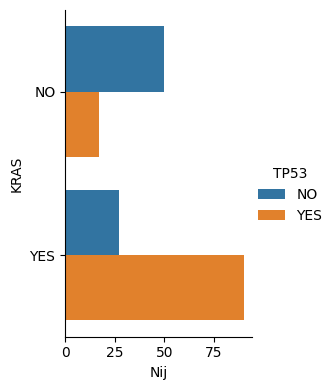

In [48]:
df_data.rename(columns={ "data1": mutation_name1, "data2": mutation_name2 }, inplace=True)
sns.catplot(y=mutation_name1, x="Nij",hue=mutation_name2,data=df_data, kind="bar",height=4, aspect=.7)

##  Compute the statistics
After sumarizing the data in the table above, we are in the position to perform the 2-sided Fisher's Exact test for the null hypothesis that no nonrandom associations exist between the two categorical variables (Somatic mutations). For clarity we consider the following 2x2 contingency table.

|-         |-     |Gene2|    |
|:--       |:-- |:--- |:---|
|-         |-    |YES  |NO  |
|**Gene1** |YES |$a$    |$b$   |
|-          |NO  |$c$    |$d$   |

To compute the p-Value of the Fisher's test, we need to compute the Hypergeometric distribution:

$$Pr(x) = \frac{(a+b)!(c+d)!(a+c)!(b+d)! }{x!(a+b-x)!(a+c-x)!(d-a+x)!n!} $$

Where $n=a+b+c+d$. The p-Value is then computed by:

$$p_{FET}(a,b,c,d) = \sum_{x} Pr(x) \ I\left[ Pr(x) \leq Pr(a) \right]  $$

Efficient computation of  $p_{FET}$ using BigQuery commands would be very difficult due to the factorials. Instead we take advantage of the possibility of implementing User-Defined Functions using JavaScript. We implemented a public User-defined function called pFisherExact that computes $p_{FET}$. The source code and an example of how to use this function in  Bigquery can be found in: https://github.com/isb-cgc/Community-Notebooks/tree/master/BQUserFunctions#p_fisherexact


The following BigQuery string has the steps to compute $a$, $b$, $c$, and $d$ as indicated above and then uses the BigQuery function `p_fisherexact_current` to compute the p-Value of the Fisher exact test.  

In [49]:
query_fishertest = """
SELECT a,b,c,d,
      `isb-cgc-bq.functions.p_fisherexact_current`(a,b,c,d) as pValue
FROM (
SELECT
  MAX( IF( (data1='YES') AND (data2='YES'), Nij, NULL ) ) as a ,
  MAX( IF( (data1='YES') AND (data2='NO') , Nij, NULL ) ) as b ,
  MAX( IF( (data1='NO') AND (data2='YES') , Nij, NULL ) ) as c ,
  MAX( IF( (data1='NO') AND (data2='NO')  , Nij, NULL ) )  as d
FROM summ_table
)
WHERE a IS NOT NULL AND b IS NOT NULL AND c IS NOT NULL AND d IS NOT NULL
"""

sql = (  sql_data +  query_fishertest )

df_results = pandas_gbq.read_gbq(sql,project_id=my_project_id )

df_results

Downloading: 100%|██████████|


,a,b,c,d,pValue
0,90,27,17,50,8.046829e-12


To test our implementation we can use the 'fisher_exact' function available in python

In [50]:
a = df_results['a'][0]
b = df_results['b'][0]
c = df_results['c'][0]
d = df_results['d'][0]

oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]])
pvalue

8.046828829096647e-12